In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import glob
import numpy as np
import xgboost as xgb


In [6]:
cornbelters_files = glob.glob("../kclData/*.csv")
other_files = glob.glob("../CornBeltersData/*.csv")

all_files = cornbelters_files + other_files

# Read and concatenate all CSVs into one DataFrame
stuff_plus = [pd.read_csv(f) for f in all_files]
df = pd.concat(stuff_plus, ignore_index=True)


In [7]:
#Combine PitchCall KorBB and PlayResult into one column
def combined_columns(event):
    #If there is a value in KorBB return that since PlayResult sometimes does not have KorBB
    if not pd.isna(event['KorBB']):
        return event['KorBB']
    #If the ball is in play in pitchcall we want to return the result to map it
    if event['PitchCall'] == 'InPlay':
        return event['PlayResult']
    #Since we already have if there's a strikeout or if there's an inplay
    else:
        return event['PitchCall']

In [8]:
df['pitch_by_pitch'] = df.apply(combined_columns,axis=1)

In [9]:
mapping_data = pd.read_csv('mean_delta_run_exp_by_outcome_count.csv')

# Map the data: Group by pitch_by_pitch, Balls, and Strikes, and calculate the mean of delta_run_exp_mean
df = df.merge(mapping_data, on=['pitch_by_pitch', 'Balls', 'Strikes'], how='left')

In [10]:
dft = df[['TaggedPitchType','delta_run_exp_mean','Pitcher','pitch_by_pitch','RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak','VertApprAngle','ZoneSpeed','VertRelAngle']]

# Create dummy variables for TaggedPitchType
dummies = pd.get_dummies(dft['TaggedPitchType'], prefix='PitchType',dtype=float)
dft = pd.concat([dft, dummies], axis=1)
pitch_type_dummies = [col for col in dft.columns if col.startswith('PitchType_')]


In [11]:
pitch_type_dummies

['PitchType_Changeup',
 'PitchType_Curveball',
 'PitchType_Cutter',
 'PitchType_Fastball',
 'PitchType_Knuckleball',
 'PitchType_Sinker',
 'PitchType_Slider',
 'PitchType_Splitter']

In [12]:
dft = dft.dropna()

In [13]:
offspeed_pitches = ['Sinker','Curveball','Slider','Cutter']

def calculate_ff_diff(event):
    """Calculate fastball speed difference with error handling"""
    if pd.notna(event['RelSpeed']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = df[(df['Pitcher'] == event['Pitcher']) & 
                         (df['TaggedPitchType'] == 'Fastball')]['RelSpeed'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['RelSpeed']
    return np.nan

def calculate_ivb_diff(event):
    """Calculate induced vertical break difference with error handling"""
    if pd.notna(event['InducedVertBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = df[(df['Pitcher'] == event['Pitcher']) & 
                         (df['TaggedPitchType'] == 'Fastball')]['InducedVertBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['InducedVertBreak']
    return np.nan

def calculate_hb_diff(event):
    """Calculate horizontal break difference with error handling"""
    if pd.notna(event['HorzBreak']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = df[(df['Pitcher'] == event['Pitcher']) & 
                         (df['TaggedPitchType'] == 'Fastball')]['HorzBreak'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['HorzBreak']
    return np.nan
def calculate_angle_diff(event):
    """Calculate vertical approach angle difference with error handling"""
    if pd.notna(event['VertRelAngle']) and pd.notna(event['TaggedPitchType']) and event['TaggedPitchType'] in offspeed_pitches:
        fastball_avg = df[(df['Pitcher'] == event['Pitcher']) & 
                         (df['TaggedPitchType'] == 'Fastball')]['VertRelAngle'].mean()
        if pd.notna(fastball_avg):
            return fastball_avg - event['VertRelAngle']
    return np.nan

In [15]:
dft['ff_diff'] = dft.apply(calculate_ff_diff, axis=1)
dft['ivb_diff'] = dft.apply(calculate_ivb_diff, axis=1)
dft['hb_diff'] = dft.apply(calculate_hb_diff, axis=1)
dft['ang_diff'] = dft.apply(calculate_angle_diff, axis=1)
    

In [16]:
features = ['RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak','VertRelAngle', 'HorzBreak','VertApprAngle','ZoneSpeed','ff_diff','ivb_diff','hb_diff','ang_diff'] + pitch_type_dummies

In [17]:
dft['VertRelAngle'] = dft['VertRelAngle'].round(10)
dft['ang_diff'] = dft['ang_diff'].round(10)

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
from scipy.stats import uniform, randint


# Prepare data
X = dft[features]
y = dft['delta_run_exp_mean']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



In [19]:
# Create pipeline
final_model = make_pipeline(
    RobustScaler(),
    XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=0,                  # Set this explicitly
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        colsample_bylevel=0.8,
        colsample_bynode=0.8,
        gamma=0.0,
        reg_alpha=0.1,
        reg_lambda=0.2,
        tree_method='hist',           # Efficient for large datasets
        random_state=42
    )
)


# Set up RandomizedSearchCV


# Run RandomizedSearchCV
final_model.fit(X_train, y_train)

# Final model training with best params


# Predictions
y_pred = final_model.predict(X_test)

# Evaluate
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE (RandomizedSearchCV Tuned): {rmse}")

# Optional: Check prediction range
print("Min Prediction:", y_pred.min(), "Max Prediction:", y_pred.max())
print("Mean Prediction:", y_pred.mean())

# Baseline comparison
y_pred_baseline = np.full_like(y_test, y_train.mean())
rmse_baseline = sqrt(mean_squared_error(y_test, y_pred_baseline))
print(f"Baseline RMSE (Mean Prediction): {rmse_baseline}")


Test RMSE (RandomizedSearchCV Tuned): 0.19889253889583158
Min Prediction: -0.97019595 Max Prediction: 2.7525706
Mean Prediction: -0.05011419
Baseline RMSE (Mean Prediction): 0.25854541596245284


In [20]:
y_pred.std()

np.float32(0.2218208)

In [21]:
y_pred_baseline = np.full_like(y_test, y_train.mean())
rmse_baseline = sqrt(mean_squared_error(y_test, y_pred_baseline))
print(f"Baseline RMSE (Mean Prediction): {rmse_baseline}")

Baseline RMSE (Mean Prediction): 0.25854541596245284


In [22]:
print("Min Prediction:", y_pred.min(), "Max Prediction:", y_pred.max())
print("Mean Prediction:", y_pred.mean())

Min Prediction: -0.97019595 Max Prediction: 2.7525706
Mean Prediction: -0.05011419


In [23]:
print("X_train NaN:", y_test.shape)
print("y_train NaN:", y_pred.shape)
print("y_train unique values:", y_train.nunique())

X_train NaN: (14361,)
y_train NaN: (14361,)
y_train unique values: 347


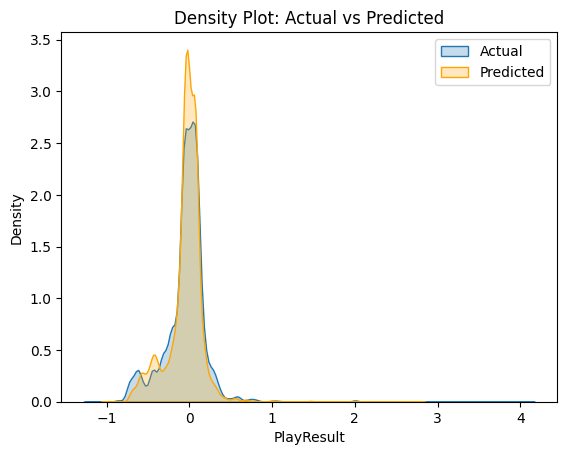

In [24]:
sns.kdeplot(y_test, label='Actual', fill=True)
sns.kdeplot(y_pred, label='Predicted', fill=True, color='orange')
plt.xlabel('PlayResult')
plt.ylabel('Density')
plt.title('Density Plot: Actual vs Predicted')
plt.legend()
plt.show()

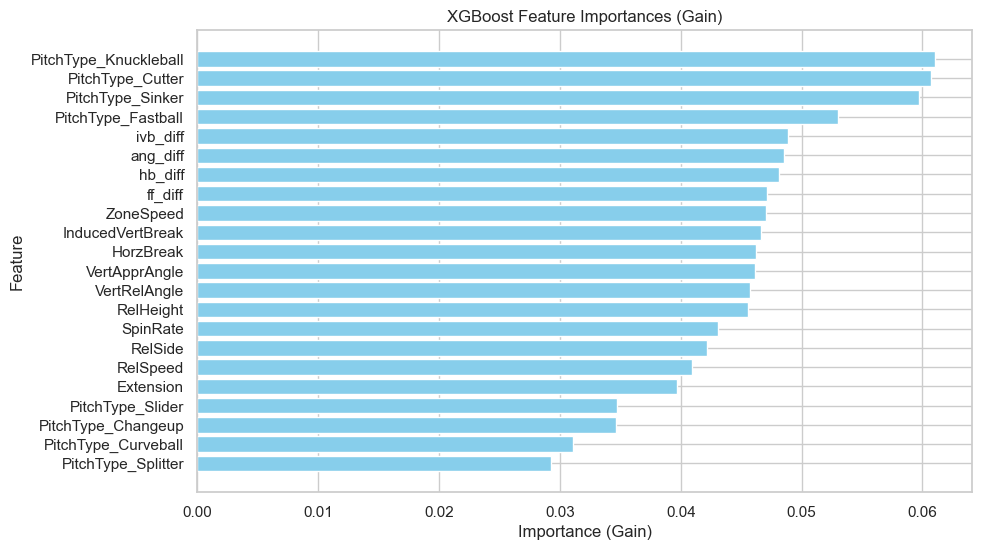


Feature Importances (Gain):
PitchType_Knuckleball: 0.0611
PitchType_Cutter: 0.0607
PitchType_Sinker: 0.0597
PitchType_Fastball: 0.0530
ivb_diff: 0.0489
ang_diff: 0.0485
hb_diff: 0.0481
ff_diff: 0.0471
ZoneSpeed: 0.0470
InducedVertBreak: 0.0466
HorzBreak: 0.0462
VertApprAngle: 0.0461
VertRelAngle: 0.0458
RelHeight: 0.0456
SpinRate: 0.0431
RelSide: 0.0421
RelSpeed: 0.0409
Extension: 0.0397
PitchType_Slider: 0.0347
PitchType_Changeup: 0.0346
PitchType_Curveball: 0.0311
PitchType_Splitter: 0.0293


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import pandas as pd

# Set seaborn theme
sns.set_theme(style='whitegrid')

# Access the XGBRegressor from the pipeline
xgb_model = final_model.named_steps['xgbregressor']

# Extract feature importances (default is 'gain', normalized)
feature_importances = xgb_model.feature_importances_

# Get feature names (assuming X_train is a pandas DataFrame)
features = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'feature_{i}' for i in range(X_train.shape[1])]

# Create a Polars DataFrame for feature importances
importance_df = pl.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort(by='Importance', descending=True)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importances (Gain)')
plt.gca().invert_yaxis()
plt.show()

# Print feature importances
print("\nFeature Importances (Gain):")
for row in importance_df.iter_rows(named=True):
    print(f"{row['Feature']}: {row['Importance']:.4f}")

In [26]:
y.mean()

np.float64(-0.04835459883155868)

In [27]:
y.median()

np.float64(-0.0068717159317608)

In [28]:
y.std()

np.float64(0.25615758489641166)

In [29]:
import pickle

In [30]:
with open("stuff_plus_model.pkl", "wb") as f:
    pickle.dump(final_model, f)